In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
import hublib.ui as ui
mpl.rc('animation', html='jshtml')

<IPython.core.display.Javascript object>

# Heat Transfer in Steady Pipe Flow

In this example, we consider a steady flow through a heated pipe. This is a simplified example of what happens in a water heater. The pipe is heated, for example, by a heating element wrapped around the outside of the pipe, and the heat is transferred to the water that flows through the pipe. We will obtain the energy balance for the fluid flowing in the pipe, which allows us to calculate the heat transfer and the spatial temperature profile along the pipe.

Consider a pipe of lenght $L$ and radius $r$ as shown in the figure below. A fluid is flowing through the pipe at a mass flow rate $\dot{m}$ (in $kg/s$). When entering the heated section of the pipe, the fluid has an _inlet temperature_ of $T_i$. In this example, we will consider the average temperature at any location $x$ along the pipe, that is, the temperature $T(x)$ is averaged over the radial coordinate of the cross-section at $x$. The heating element provides a constant heat flux $q''$ to the fluid at the surface of the pipe.

![Heated Pipe Flow](assets/pipe.png)

Due to the heat transfer from the pipe to the fluid, the temperature of the fluid will rise as it flows through the pipe, and it will be discharged at an _outlet temperature_ $T_o$. 

## External heat transfer at constant heat flux $q''$

### Energy balance

Consider a control volume that is a small segment of the pipe of length $\Delta x$, i.e., the control volume is $V=\pi r^2 \Delta x$. The rate of change of thermal energy in the control volume is thus
$$ \dot{E}_\text{st} = \rho c_p \frac{\partial T(x,t)}{\partial t} \pi r^2 \Delta x$$
To perform an energy balance for this control volume, we consider the thermal energy of the fluid flowing in an out of the segment, and the energy transferred by the heat flux $q''$. The rate at which thermal energy enters the control volume is 
$$ \dot{E}_\text{in} = \dot{m} c_p T(x) + 2\pi r q'' \Delta x, $$
and the rate at which thermal energy leaves the control volume is 
$$ \dot{E}_\text{out} = \dot{m} c_p T(x+\Delta x) \approx \dot{m} c_p T(x) + \dot{m} c_p \Delta x \frac{\partial T(x)}{\partial x}.$$
The energy balance thus reads
$$ \pi r^2 \rho c_p \frac{\partial T(x,t)}{\partial t} = 2\pi r q'' - \dot{m} c_p \frac{\partial T(x,t)}{\partial x}.$$

### Steady-state solution

Under steady-state conditions, the temperature profile $T(x)$ along the pipe is described by the ordinary differential equation
$$ \dot{m} c_p \frac{\partial T(x,t)}{\partial x} = 2\pi r q'' .$$
The general solution of this equation is 
$$ T(x) = \frac{2\pi r q''}{\dot{m} c_p} x + C_1 .$$
$C_1$ can be determined by using the boundary condition
$$ T(0) = T_i, $$
which leads to
$$ T(x) = T_i + \frac{2\pi r q''}{\dot{m} c_p} x .$$

Let us plot this solution:

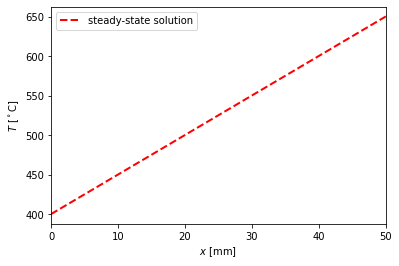

In [2]:
L = 50     # pipe length in meter
r = 0.1    # pipe radius in meter
m = 3      # mass flow rate in kg/s
cp = 4180  # specific heat capacity of water in J/kg*K
rho = 1000 # density of water in kg/m^3
Ti = 400   # inlet temperature in K
T0 = 300   # initial fluid temperature in K
q_flux = 100000 # heat flux in W/m^2

def steady_state(x):
    T = Ti + (2*np.pi*r*q_flux)/(m*cp)*x
    return T

xs = np.linspace(0,L,20)
plt.plot(xs,steady_state(xs),'r--',lw=2,label='steady-state solution')
plt.xlabel(r'$x\ \mathrm{[mm]}$')
plt.ylabel(r'$T\ \mathrm{[^\circ C]}$')
plt.xlim(0,L)
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.show()

### Finite Difference Formulation

The transient solution can be obtained by solving the energy balance numerically. Similar to what we have done for the 1D heat diffusion equation, we replace the partial derivatives by finite differences. This leads us to the algebraic equation
$$ T(x,t+\Delta t) = T(x,t) + \frac{\dot{m}\Delta t}{\pi r^2 \rho} \left[ \frac{2 \pi r q''}{\dot{m} c_p} - \frac{T(x,t)-T(x-\Delta x,t)}{\Delta x} \right] .$$

To use this equation as an update rule, we define a discrete spacing $\Delta x$ and a discrete time step $\Delta t$ and calculate the coordinates `xs` along the pipe and the discrete times `ts`, assuming that we want to integrate up to time `time`.

In [3]:
n = 100    # number of nodes
time = 700 # time in s

dx = L/n
dt = 1.0

xs = np.arange(0,L+dx,dx)
ts = np.arange(0,time+dt,dt)

Looking at the update equation, we see that we only need a boundary condition for $T(x=0)$ at the inlet, since only the left neighbor of every nodes is needed. The inlet boundary condition is a Dirichlet boundary condition, i.e., $T(x=0)=T_i$ at all times. We can thus define a function that computes the transient solution as follows:

In [4]:
def transient():
    Ts = np.zeros((len(ts),len(xs)))
    Ts[0] = [T0]*len(xs) # initial condition
    T = Ts[0].copy()
    for t in range(len(ts)-1):
        T[0] = Ti # Dirichlet boundary condition
        dTdx = (T[1:]-T[:-1])/dx
        T[1:] += dt/(rho*cp*np.pi*r**2)*(2*np.pi*r*q_flux - m*cp*dTdx)
        Ts[t+1] = T
    return Ts

Let us plot the solution at selected times along with the steady-state solution:

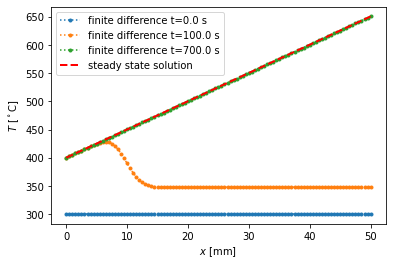

In [5]:
Ts = transient()
for t in [0,100,time]:
    plt.plot(xs,Ts[t],'.:',label='finite difference t=%.1f'%ts[t]+' s')
plt.plot(xs,steady_state(xs),'r--',lw=2,label='steady state solution')
plt.xlabel(r'$x\ \mathrm{[mm]}$')
plt.ylabel(r'$T\ \mathrm{[^\circ C]}$')
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.show()

The widget below allows you to explore how the water heating is affected by the flow rate $\dot{m}$ and the heat flux $q''$.

In [6]:
def animate1d(T,frames=100,interval=50):
    step = len(T)//frames
    T = np.vstack([T[0],T[1::step]])

    def init():
        profile.set_data(xs,T[0])
        time_text.set_text('t={0:.4f} s'.format(0))
        return (profile,time_text)

    def animate(i):
        profile.set_data(xs,T[i])
        time_text.set_text('t={0:.4f} s'.format(i*dt*step))
        return (profile,time_text)
  
    Tmax = max(750,np.max(steady_state(xs)))
    Tmin = min(298,np.min(steady_state(xs)))

    fig, ax = plt.subplots()
    ax.plot(xs,steady_state(xs),'r--',lw=2,label='steady-state solution')
    profile, = ax.plot(xs,Ts[0],'r',label='transient solution')
    ax.set_ylim(Tmin-(Tmax-Tmin)/10,Tmax+(Tmax-Tmin)/10)
    ax.set_title('Temperature along the pipe')
    ax.set_xlabel('x')
    ax.set_ylabel('T')
    ax.ticklabel_format(useOffset=False)
    ax.legend(loc=3)
    time_text = ax.text(0.7, 0.9, 't=0 s', transform=ax.transAxes, color='k', fontsize=14)
    
    ani = mpl.animation.FuncAnimation(fig, animate, init_func=init,
                                      frames=frames, interval=interval, blit=True)
    plt.close()
    return ani

In [7]:
def animate_transient(name='', value=''):
    global time, ts, m, q_flux
    
    # set parameters
    time = t_widget.value # observation time
    m = m_widget.value # mass flow rate
    q_flux = q_widget.value # heat flux
    ts = np.arange(0,time+dt,dt)
    Ts = transient()
    
    ani = animate1d(Ts,frames=40,interval=100)
    with out_widget:
        out_widget.clear_output(wait=True)
        display(ani)
    return ani

t_widget = ui.Number(
    name = 'time',
    desc = 'total observation time',
    value = 700,
    cb = animate_transient
)
m_widget = ui.Number(
    name = 'm',
    desc = 'mass flow rate',
    value = 3,
    cb = animate_transient
)
q_widget = ui.Number(
    name = 'q',
    desc = 'heat flux',
    value = 100000,
    cb = animate_transient
)

out_widget = widgets.Output(layout=widgets.Layout())

display(ui.Form([out_widget,t_widget,m_widget,q_widget]))
ani = animate_transient() # this call ensures that the animation is shown in the widget

Group(children=(Output(), Number(children=(HTML(value='<div data-toggle="popover" title="total observation tim…